In [1]:
import numpy as np

def compute_K_vectors(as_param, aq_param, cs_param, cq_param, rho_s, rho_q, sigma_squared, eta):
    """
    Compute the K vectors as defined in Equation 22
    
    Parameters:
    -----------
    as_param, aq_param: Parameters for the short-run and long-run volatility components
    cs_param, cq_param: Leverage parameters for the short-run and long-run components
    rho_s, rho_q: Persistence parameters for short-run and long-run components
    sigma_squared: Unconditional variance
    eta: Parameter for IG innovations
    
    Returns:
    --------
    K1, K2, K3, K4, K5: The K vectors as defined in Equation 22
    """

    # Define K2 and K3
    K2 = np.array([as_param, aq_param])
    K3 = np.array([cs_param, cq_param])
    
    # Compute K1
    K1 = np.array([0, sigma_squared * (1 - rho_q)]) - eta**4 * K2
    
    # Compute K4
    K4 = np.array([rho_s, 0]) - eta**2 * K2 - (1/eta**2) * K3
    
    # Compute K5
    K5 = np.array([0, rho_q]) - eta**2 * K2 - (1/eta**2) * K3
    
    return K1, K2, K3, K4, K5

def compute_kappa_values(theta_l, theta_y, K2, K3, eta):
    """
    Compute κ₁ and κ₂ as defined in Equations 25 and 26
    
    Parameters:
    -----------
    theta_l: Vector of factor risk preference parameters [theta_s, theta_q]
    theta_y: Equity risk preference parameter
    K2, K3: K vectors from Equation 22
    eta: Parameter for IG innovations
    lambda_param: Equity risk premium parameter
    
    Returns:
    --------
    kappa1, kappa2: Values of κ₁ and κ₂
    """
    # Calculate kappa1 (Equation 25)
    kappa1 = 1 - 2 * eta**4 * np.dot(theta_l, K2)
    
    # Calculate kappa2 (Equation 26)
    kappa2 = 1 - 2 * theta_y * eta - 2 * np.dot(theta_l, K3)
    
    return kappa1, kappa2

In [2]:
def compute_theta_l(theta_s, theta_q):
    """
    Compute θl based on Equation 21 from the JF paper
    
    Parameters:
    -----------
    theta_s, theta_q : float
        Factor risk preference parameters
    
    Returns:
    --------
    theta_l : array-like
        Vector of factor risk preference parameters [theta_s, theta_q]
    """
    theta_l = np.array([theta_s, theta_q])
    return theta_l

def compute_theta_y(theta_l, lambda_param, eta, K2, K3):
    """
    Compute θy based on Equation 23 from the JF paper
    
    Parameters:
    -----------
    theta_l : array-like
        Vector of factor risk preference parameters [theta_s, theta_q]
    lambda_param : float
        Equity risk premium parameter
    eta : float
        Parameter for IG innovations
    K2, K3 : array-like
        K vectors from Equation 22
    
    Returns:
    --------
    theta_y : float
        Equity risk preference parameter
    """
    # Term 1: (1 - 2θl^T K3)/(2η)
    term1 = (1 - 2 * np.dot(theta_l, K3)) / (2 * eta)

    
    
    num = lambda_param**2 * eta**3 + 2 * (1 - 2 * eta**4 * np.dot(theta_l, K2))
    denom = 8 * lambda_param**2 * eta**3 * (1 - 2 * eta**4 * np.dot(theta_l, K2))
    term2 = num**2 / denom
    
    # Combine the terms to get θy
    theta_y = term1 - term2
    
    return theta_y

In [3]:
def compute_model_params_and_vectors(eta, lam, K1, K2, K3, K4, K5, kappa1, kappa2):
    """
    Compute the model parameters and vectors for IG_GARCH(C)
    
    Parameters:
    -----------
    eta: Parameter for IG innovations
    lam: Equity risk premium parameter
    K1, K2, K3, K4, K5: K vectors from Equation 22
    kappa1, kappa2: Values of κ₁ and κ₂ from Equations 25 and 26
    
    Returns:
    --------
    eta*, lambda*, K1*, K2*, K3*, K4*, K5*: Model parameters and vectors for IG_GARCH(C)
    """
    
    # Compute eta*
    eta_star = eta / kappa2

    # Compute lambda*
    lam_star = lam * np.sqrt((kappa2**3)/kappa1)

    # Compute K1*
    K1_star = K1 * np.sqrt(kappa1/(kappa2**3))

    # Compute K2*
    K2_star = K2 * np.sqrt((kappa2**5)/kappa1)

    # Compute K3*
    K3_star = K3 * np.sqrt(kappa1/(kappa2**5))

    # Compute K4*
    K4_star = K4

    # Compute K5*
    K5_star = K5
    
    return eta_star, lam_star, K1_star, K2_star, K3_star, K4_star, K5_star

In [4]:
import numpy as np
import functools  # for memoizing the recursive functions

def compute_A_and_B_star_functions(**params):
    """
    Create functions for computing A*, B*, B0* with memoization
    
    Parameters:
    -----------
    params: dict containing model parameters including numpy arrays
    
    Returns:
    --------
    Three functions for computing A*, B*, and B0*
    """
    eta_star = params['eta_star']
    lam_star = params['lam_star']
    K1_star = params['K1_star']
    K2_star = params['K2_star']
    K3_star = params['K3_star']
    K4_star = params['K4_star']
    K5_star = params['K5_star']
    r = params["r"]
    
    # Create hashable versions of the numpy arrays
    params_hashable = {
        'eta_star': eta_star,
        'lam_star': lam_star,
        'K1_star': tuple(map(float, K1_star)),
        'K2_star': tuple(map(float, K2_star)),
        'K3_star': tuple(map(float, K3_star)),
        'K4_star': tuple(map(float, K4_star)),
        'K5_star': tuple(map(float, K5_star)),
        'r': r
    }
    
    # Create a key for the memoization cache
    cache_key = hash(frozenset(params_hashable.items()))
    
    # Define the memoized functions
    @functools.lru_cache(maxsize=None)
    def compute_B_star(u, v_tuple, t, T, key):
        """
        Compute the B* function for IG_GARCH(C)
        
        Parameters:
        -----------
        u: complex number
        v_tuple: tuple, hashable version of v
        t, T: time periods
        key: hash to identify parameter set
        
        Returns:
        --------
        Tuple representation of B* vector
        """
        if t == T:
            return v_tuple
        else:         
            # Calculate components
            B_s = compute_B_s_star(u, v_tuple, t, T, key)
            B_q = compute_B_q_star(u, v_tuple, t, T, key)
            
            return (B_s, B_q)
    
    @functools.lru_cache(maxsize=None)
    def compute_B_s_star(u, v_tuple, t, T, key):
        if t == T:
            return v_tuple[0] if len(v_tuple) > 0 else 0.0
        else:
            B_star_tplus1 = np.array(compute_B_star(u, v_tuple, t+1, T, key))

            
            # Use numpy arrays for vector operations
            K2_star_array = np.array(K2_star)
            K3_star_array = np.array(K3_star)
            K4_star_array = np.array(K4_star)
            
            # Compute and print intermediate values
            K2_product = np.dot(B_star_tplus1, K2_star_array)
            K3_product = np.dot(B_star_tplus1, K3_star_array)
                    
            term1 = 1 - 2 * eta_star**4 * K2_product
            term2 = 1 - 2 * u * eta_star - 2 * K3_product
            root = np.sqrt(term1 * term2)
            
            result = u*lam_star + np.dot(B_star_tplus1, K4_star_array) + (1 - root)/eta_star**2
        
        return result
    
    @functools.lru_cache(maxsize=None)
    def compute_B_q_star(u, v_tuple, t, T, key):
        """
        Compute the B_q* function for IG_GARCH(C)
        """
        if t == T:
            return v_tuple[1] if len(v_tuple) > 1 else 0.0
        else:
            B_star_tplus1 = np.array(compute_B_star(u, v_tuple, t+1, T, key))
            
            # Use numpy arrays for vector operations
            K2_star_array = np.array(K2_star)
            K3_star_array = np.array(K3_star)
            K5_star_array = np.array(K5_star)
            
            term1 = 1 - 2 * eta_star**4 * np.dot(B_star_tplus1, K2_star_array)
            term2 = 1 - 2 * u * eta_star - 2 * np.dot(B_star_tplus1, K3_star_array)
            root = np.sqrt(term1 * term2)
            
            result = u*lam_star + np.dot(B_star_tplus1, K5_star_array) + (1 - root)/eta_star**2
    
            return result
        
    @functools.lru_cache(maxsize=None)
    def compute_B_0_star(u, v_tuple, t, T, key):
        """
        Compute the B_0* function, which is always 0 for this model
        """
        return 0.0
    
    @functools.lru_cache(maxsize=None)
    def compute_A_star(u, v_tuple, t, T, key):
        """
        Compute the A* function for IG_GARCH(C)
        """
        if t == T:
            return 0.0
        else:
            A_star_tplus1 = compute_A_star(u, v_tuple, t+1, T, key)
            B_star_tplus1 = np.array(compute_B_star(u, v_tuple, t+1, T, key))
            
            # Use numpy arrays for vector operations
            K1_star_array = np.array(K1_star)
            K2_star_array = np.array(K2_star)
            
            log_term = 1 - 2*eta_star**4 * np.dot(B_star_tplus1, K2_star_array)
            return A_star_tplus1 + u*r + np.dot(B_star_tplus1, K1_star_array) - 0.5 * np.log(log_term)
    
    # Wrapper functions to handle the conversion between array and tuple for caching
    def wrapped_compute_A_star(u, v, t, T):
        """
        Wrapper for A* function that handles numpy arrays
        """
        if isinstance(v, np.ndarray):
            v_tuple = tuple(map(complex, v))
        else:
            v_tuple = v if isinstance(v, tuple) else (v,)
        
        return compute_A_star(u, v_tuple, t, T, cache_key)
    
    def wrapped_compute_B_star(u, v, t, T):
        """
        Wrapper for B* function that handles numpy arrays
        """
        if isinstance(v, np.ndarray):
            v_tuple = tuple(map(complex, v))
        else:
            v_tuple = v if isinstance(v, tuple) else (v,)
        
        result = compute_B_star(u, v_tuple, t, T, cache_key)
        return np.array(result)
    
    def wrapped_compute_B_0_star(u, v, t, T):
        """
        Wrapper for B0* function that handles numpy arrays
        """
        if isinstance(v, np.ndarray):
            v_tuple = tuple(map(complex, v))
        else:
            v_tuple = v if isinstance(v, tuple) else (v,)
        
        return compute_B_0_star(u, v_tuple, t, T, cache_key)
    
    return wrapped_compute_A_star, wrapped_compute_B_star, wrapped_compute_B_0_star

In [5]:
def log_psi_0(t, y_t, l_star_t, r, A_star, B0_star, B_star):
    """
    Compute psi_0_t value as defined in Proposition 2
    """
    zero = np.zeros(2)

    # Computing A_star(2, 0; t, t+1)
    A_star_val = A_star(2, zero, t, t+1)
    
    # Computing B0_star(2, 0; t, t+1)
    B0_star_val = B0_star(2, zero, t, t+1)
    
    # Computing B_star(2, 0; t, t+1)
    B_star_val = B_star(2, zero, t, t+1)
    

    dot_product = np.dot(B_star_val, l_star_t)

    log_term = -2*r + A_star_val + B0_star_val * y_t + dot_product

    return log_term
    
def log_psi_1(t, z, y_t, l_star_t, A_star, B0_star, B_star, T):
    """
    Compute psi_1_t(z) value as defined in Proposition 2
    """
    zero = np.zeros(2)

    # Computing A_star(z, 0; t, T)
    A_star_val = A_star(z, zero, t, T)
    
    # Computing B0_star(z, 0; t, T)
    B0_star_val = B0_star(z, zero, t, T)
    
    # Computing B_star(z, 0; t, T)
    B_star_val = B_star(z, zero, t, T)
    

    dot_product = np.dot(B_star_val, l_star_t)

    
    log_term = A_star_val + B0_star_val * y_t + dot_product

    return log_term


def log_psi_2(t, z, y_t, l_star_t, r, A_star, B0_star, B_star, T):
    """
    Compute psi_2_t(z) value as defined in Proposition 2
    """
    zero = np.zeros(2)

    # Computing A_star(z, 0; t+1, T)
    A_star_val_1 = A_star(z, zero, t+1, T)
    
    # Computing B0_star(z, 0; t+1, T)
    B0_star_val = B0_star(z, zero, t+1, T)
    
    # Computing B_star(z, 0; t+1, T)
    B_star_val = B_star(z, zero, t+1, T)
    
    # Computing A_star(1 + z + B0_star(z, 0; t+1, T), B_star(z, 0; t+1, T); t, t+1)
    A_star_val_2 = A_star(1 + z + B0_star_val, B_star_val, t, t+1)
    
    # Computing B0_star(1 + z + B0_star(z, 0; t+1, T), B_star(z, 0; t+1, T); t, t+1)
    B0_star_val_2 = B0_star(1 + z + B0_star_val, B_star_val, t, t+1)
    
    # Computing B_star(1 + z + B0_star(z, 0; t+1, T), B_star(z, 0; t+1, T); t, t+1)
    B_star_val_2 = B_star(1 + z + B0_star_val, B_star_val, t, t+1)
    

    dot_product = np.dot(B_star_val_2, l_star_t)

    log_term1 = -r + A_star_val_1 + A_star_val_2
    log_term2 = B0_star_val_2 * y_t
    log_term3 = dot_product
    
    # Computing psi_2_t(z)
    log_term = log_term1 + log_term2 + log_term3
    
    return log_term

In [30]:
def f_check_call(z, K):
    """
    Inverse Laplace transform of a European call option payoff
    
    Parameters:
    z: complex variable for the integration
    K: strike price
    
    Returns:
    Inverse Laplace transform value
    """
    return K**(1-z) / (z * (z - 1))

def f_check_put(z, K):
    """
    Inverse Laplace transform of a European put option payoff
    
    Parameters:
    z: complex variable for the integration
    K: strike price
    
    Returns:
    Inverse Laplace transform value
    """
    return K**(1-z) / (z * (z - 1)) * (-1)  # The put option payoff has opposite sign

In [14]:
def compute_l_t_star(s_t, q_t, delta):
    """
    Compute the scaled factor vector at time t
    
    Parameters:
    s_t: Short-run component at time t
    q_t: Long-run component at time t
    delta: Scaling factor
    
    Returns:
    l_t_star: Scaled factor vector at time t
    """
    l_t_star = np.array([s_t, q_t]) * delta
    return l_t_star

In [32]:
from scipy import integrate
def risk_minimizing_hedge(t, T, y_t, l_star_t, r, A_star, B0_star, B_star, f_check, option_params, R):
    """
    Compute the risk-minimizing hedging position using equation (8)
    """
    # Computing psi_0_t
    log_psi_0_val = log_psi_0(t, y_t, l_star_t, r, A_star, B0_star, B_star)
        
    # Defining the integrand function for numerical integration
    def integrand_for_quad(y):
        z = complex(R, y)
        # Calculate components directly here for debugging
        log_psi_1_val = log_psi_1(t, z, y_t, l_star_t, A_star, B0_star, B_star, T)
        log_psi_2_val = log_psi_2(t, z, y_t, l_star_t, r, A_star, B0_star, B_star, T)

        psi_diff = np.exp(log_psi_2_val) - np.exp(log_psi_1_val)
        exp_term = np.exp((z-1) * y_t)
        f_val = f_check(z, **option_params)


        # Calculate the integrand value
        integrand_value = exp_term * psi_diff * f_val
        
        # Since dz = i*dy, and we have 1/(2πi) in front, we need the real part of integrand_value
        # The factor i from dz cancels with the i in the denominator
        return integrand_value.real
    
    # Integrate over smaller segments for better diagnostics
    segments = [(-100, -50), (-50, -10), (-10, -1), (-1, 1), (1, 10), (10, 50), (50, 100)]
    total_integral = 0
    
    for start, end in segments:
        segment_result, _ = integrate.quad(integrand_for_quad, start, end, limit=1000)

        total_integral += segment_result

    num = np.exp(-r * (T - t)) 

    
    # Computing the final result
    xi_t_plus_1 = np.exp(-r * (T - t)) / (2 * (np.exp(log_psi_0_val) - 1) * np.pi) * total_integral
    
    return xi_t_plus_1

In [33]:
def option_price(t, T, y_t, l_star_t, r, A_star, B0_star, B_star, f_check, option_params, R):
    """
    Compute the option price using equation (9)
    
    Parameters:
    t: current time point
    T: option maturity
    y_t: log of asset price at time t
    l_star_t: scaled factor vector at time t
    r: risk-free rate
    A_star, B0_star, B_star: Functions to compute the coefficients
    f_check: Inverse Laplace transform of the option payoff
    option_params: Parameters for the option payoff (e.g., strike price)
    R: Real part of the contour in the complex plane
    
    Returns:
    Option price
    """
    # Defining the complex contour for numerical integration
    # We'll use a contour that goes vertically through R + i*y for y in [-N, N]
    N = 100  # Limit for numerical integration
    
    # Defining the integrand function for the given parameters
    def price_integrand(y):
        z = complex(R, y)
        # Computing e^{zY_t}
        exp_term = np.exp(z * y_t)
        
        # Computing ψ^{(1)}_t(z)
        psi_1_val = np.exp(log_psi_1(t, z, y_t, l_star_t, A_star, B0_star, B_star, T))
        
        # Computing \check{f}(z)
        f_check_val = f_check(z, **option_params)
        
        # Computing the integrand
        result = exp_term * psi_1_val * f_check_val
        
        return result.real
    
    # Computing the integral using numerical integration
    integral_result, _ = integrate.quad(price_integrand, -N, N, limit=1000)
    
    # Computing the final result
    price = np.exp(-r * (T - t)) * integral_result / (2 * np.pi)
    
    return price

# Testing out my code

In [5]:
#avg params dont necessarily exist
sigma_squared = 1.1676e-4
rho_s = 0.79656
a_s = 2.1765e7
c_s = 1.7172e-6
rho_q = 0.99124
a_q = 3.6037e7
c_q = 2.4548e-6
eta = -6.0027e-4
theta_s = 2.6168e4
theta_q = 4.9589e4
lam = 2.6591 - eta**-1

In [6]:
# specific params
a_h = 6.4848e6
c_h = 2.4095e-6


sigma_squared = 1.2134e-4
rho_s = 0.8203
a_q = 1.4464e7
c_q = 3.1966e-6
a_s = a_h + a_q
c_s = c_h + c_q
rho_q = 0.9877

eta = -6.5861e-4
theta_s = 2.0435e3
theta_q = 2.3441e4
lam = 2.1239 - eta**-1

In [7]:
print("Computing the K vectors...")
K1, K2, K3, K4, K5 = compute_K_vectors(a_s, a_q, c_s, c_q, rho_s, rho_q, sigma_squared, eta)
print("K1:", K1)
print("K2:", K2)
print("K3:", K3)
print("K4:", K4)
print("K5:", K5)

Computing the K vectors...
K1: [-3.94159894e-06 -1.22897637e-06]
K2: [20948800. 14464000.]
K3: [5.6061e-06 3.1966e-06]
K4: [-21.19081665 -13.64339972]
K5: [-22.01111665 -12.65569972]


In [8]:
print("Computing the θl vector...")
theta_l = compute_theta_l(theta_s, theta_q)
print("θl:", theta_l)

Computing the θl vector...
θl: [ 2043.5 23441. ]


In [9]:
print("Computing the θy parameter...")
theta_y = compute_theta_y(theta_l, lam, eta, K2, K3)
print("θy:", theta_y)

Computing the θy parameter...
θy: 19.76079062752558


In [10]:
print("Computing the κ₁ and κ₂ values...")
kappa1, kappa2 = compute_kappa_values(theta_l, theta_y, K2, K3, eta)
print("κ₁:", kappa1)
print("κ₂:", kappa2)

Computing the κ₁ and κ₂ values...
κ₁: 0.8563032738409215
κ₂: 0.8532541767303893


In [11]:
print("Computing the model parameters and vectors...")
eta_star, lam_star, K1_star, K2_star, K3_star, K4_star, K5_star = compute_model_params_and_vectors(eta, lam, K1, K2, K3, K4, K5, kappa1, kappa2)
print("η*:", eta_star)
print("λ*:", lam_star)
print("K1*:", K1_star)
print("K2*:", K2_star)
print("K3*:", K3_star)
print("K4*:", K4_star)
print("K5*:", K5_star)

Computing the model parameters and vectors...
η*: -0.0007718801946258825
λ*: 1295.0382254587876
K1*: [-4.62773627e-06 -1.44291152e-06]
K2*: [15224442.75152921 10511644.57907463]
K3*: [7.71398137e-06 4.39851462e-06]
K4*: [-21.19081665 -13.64339972]
K5*: [-22.01111665 -12.65569972]


In [12]:
#

# Now to hedge and price

In [13]:
from HedgeAndPrice import *

In [14]:


params = {
    'eta_star': eta_star,
    'lam_star': lam_star,
    'K1_star': K1_star,
    'K2_star': K2_star,
    'K3_star': K3_star,
    'K4_star': K4_star,
    'K5_star': K5_star,
    'r': 0.05
}

# Create A*, B0*, and B* functions
A_star, B_star, B0_star = compute_A_and_B_star_functions(**params)

# Define option parameters
option_params = {
    'K': 100  # Strike price
}

# Current state
t = 0
T = 50
y_t =  np.log(100)# Log of price at time t
delta = np.sqrt(kappa1 / kappa2**3)
l_star_t = compute_l_t_star(0, sigma_squared, delta) # long and short run conditional variances at time t
r = params['r']  # Risk-free rate
R = 1.5  # Real part of the contour for European call option (R > 1)
print(r)

0.05


In [15]:
exp(log_psi_0(0, y_t, l_star_t, r, A_star, B0_star, B_star)

SyntaxError: incomplete input (930519826.py, line 1)

In [16]:
# Compute the risk-minimizing hedging position

xi_t_plus_1 = risk_minimizing_hedge(
    t, T, y_t, l_star_t, r,
    A_star, B0_star, B_star,
    f_check_call, option_params, R
)

print(f"Risk-minimizing hedging position: {xi_t_plus_1}")

Risk-minimizing hedging position: (0.00014436261012377 + 0.0j)


In [17]:

# Compute the option price
option_price_value = option_price(
    t, T, y_t, l_star_t, r,
    A_star, B0_star, B_star,
    f_check_call, option_params, R
)

print(f"Option price: {option_price_value}")

Option price: (91.7624867693062 + 0.0j)


In [22]:
def plot_func(t, T, y_t, l_star_t, r, A_star, B0_star, B_star, f_check, option_params):
    # y values
    y_vals = np.linspace(-100, 100, 1000)
    R = 2.0  # adjust as needed

    # Storage
    psi1_real, psi1_imag = [], []
    psi2_real, psi2_imag = [], []
    exp_real, exp_imag = [], []
    diff_real, diff_imag = [], []
    fval_real, fval_imag = [], []

    int_real, int_imag = [], []

    for y in y_vals:
        z = complex(R, y)
        
        # Your functions
        log_psi_1_val = log_psi_1(t, z, y_t, l_star_t, A_star, B0_star, B_star, T)
        log_psi_2_val = log_psi_2(t, z, y_t, l_star_t, r, A_star, B0_star, B_star, T)
        
        psi_1 = np.exp(log_psi_1_val)
        psi_2 = np.exp(log_psi_2_val)
        exp_term = np.exp((z - 1) * y_t)
        psi_diff = psi_2 - psi_1
        f_val = f_check(z, **option_params)

        integrand = exp_term * psi_diff * f_val* 1j
        
        # Store parts
        psi1_real.append(psi_1.real)
        psi1_imag.append(psi_1.imag)
        psi2_real.append(psi_2.real)
        psi2_imag.append(psi_2.imag)
        exp_real.append(exp_term.real)
        exp_imag.append(exp_term.imag)
        diff_real.append(psi_diff.real)
        diff_imag.append(psi_diff.imag)
        fval_real.append(f_val.real)
        fval_imag.append(f_val.imag)
        int_real.append(integrand.real)
        int_imag.append(integrand.imag)

    # Plot function
    def plot_complex_component(y_vals, real_vals, imag_vals, title):
        plt.figure(figsize=(10, 4))
        plt.plot(y_vals, real_vals, label='Real part')
        plt.plot(y_vals, imag_vals, label='Imag part', linestyle='--')
        plt.title(title)
        plt.xlabel('y')
        plt.ylabel('Value')
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()

    # Generate plots
    plot_complex_component(y_vals, psi1_real, psi1_imag, 'ψ₁(z)')
    plot_complex_component(y_vals, psi2_real, psi2_imag, 'ψ₂(z)')
    plot_complex_component(y_vals, exp_real, exp_imag, 'exp((z-1)·yₜ)')
    plot_complex_component(y_vals, diff_real, diff_imag, 'ψ₂(z) - ψ₁(z)')
    plot_complex_component(y_vals, fval_real, fval_imag, 'f̂(z)')
    plot_complex_component(y_vals, int_real, int_imag, 'Integrand')

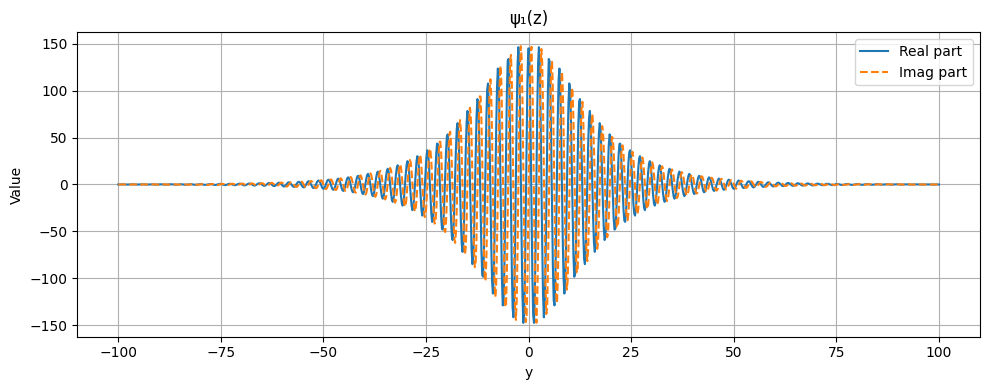

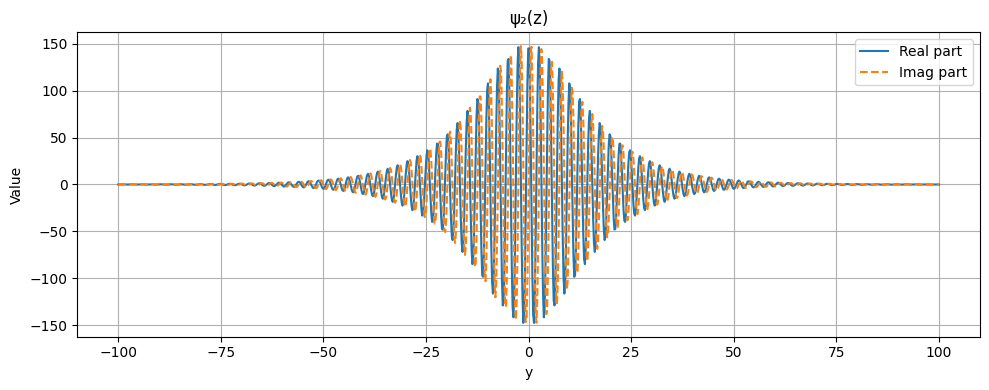

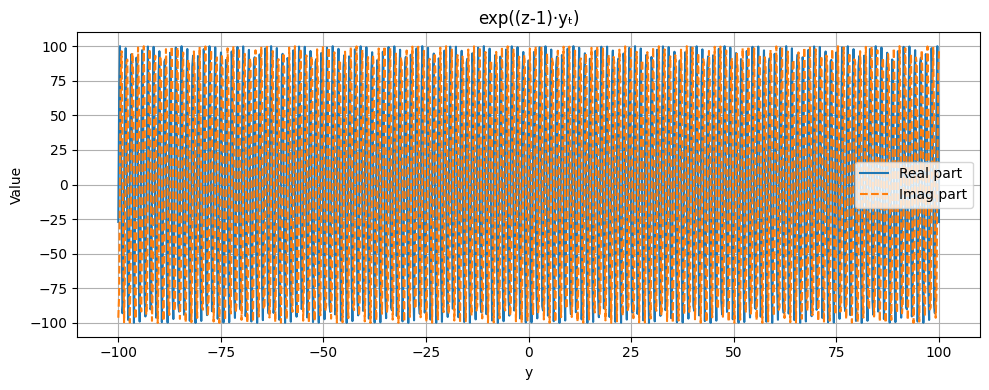

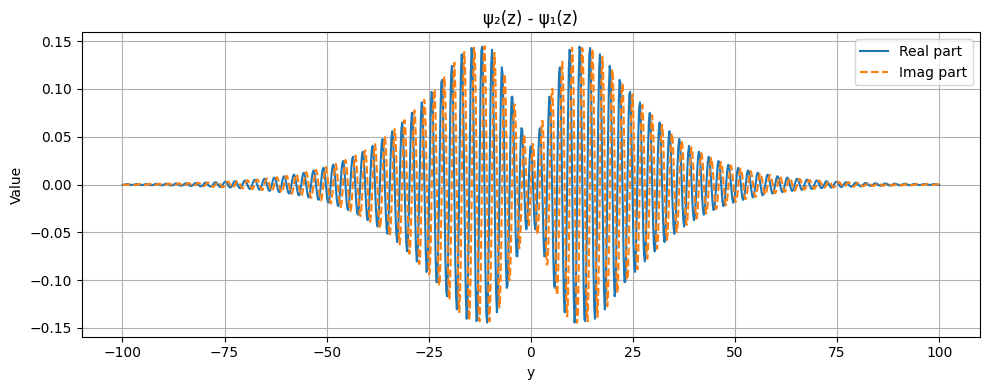

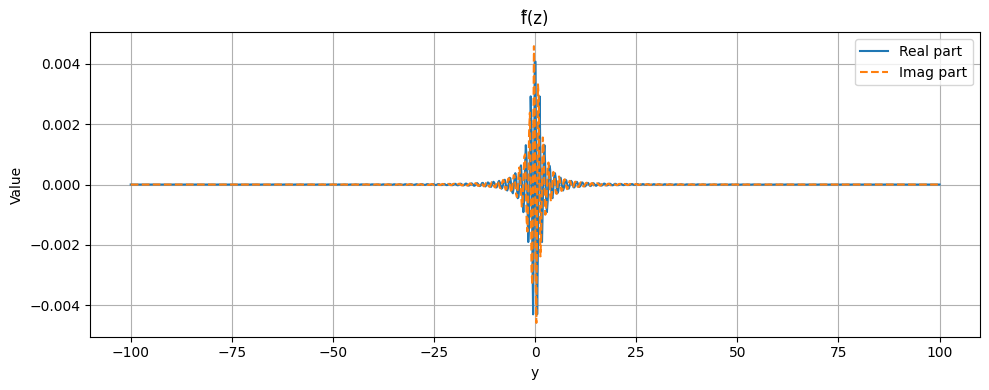

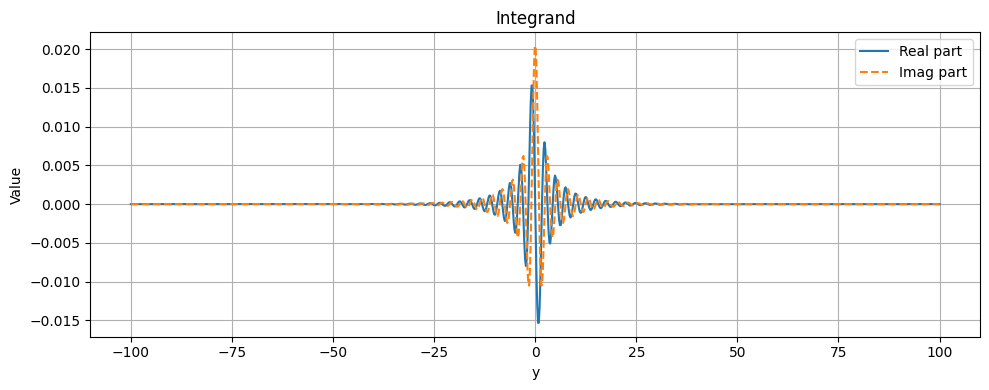

In [23]:
plot_func(t, T, y_t, l_star_t, r, A_star, B0_star, B_star, f_check_call, option_params)

In [25]:
from scipy.stats import norm

def black_scholes_price(S, K, T, r, sigma, option_type='call'):
    """
    Calculate the price of European options using the Black-Scholes formula
    
    Parameters:
    S: Current stock price
    K: Strike price
    T: Time to maturity (in years)
    r: Risk-free interest rate (annual)
    sigma: Volatility (annual)
    option_type: 'call' or 'put'
    
    Returns:
    Option price
    """
    # Calculate d1 and d2
    d1 = (np.log(S/K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    
    # Calculate option price
    if option_type.lower() == 'call':
        option_price = S * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)
    elif option_type.lower() == 'put':
        option_price = K * np.exp(-r * T) * norm.cdf(-d2) - S * norm.cdf(-d1)
    else:
        raise ValueError("option_type must be 'call' or 'put'")
    
    return option_price

In [27]:

bs_price = black_scholes_price(100, 100, 20/251, 0.05, (sigma_squared * 251)**0.5, 'call')
print("Black-Scholes Price:", bs_price)

Black-Scholes Price: 2.1664022066193027


In [64]:
(sigma_squared * 251)**0.5

0.17451744898433508

In [1]:
0.05*251

12.55

In [ ]:
# Current state
t = 0
T = 50

current_price = 100
y_t =  np.log(current_price) # Log of price at time t

for K in [50 , 100, 150]:
    option_params = {
        'K': K  # Strike price
    }

    print("K", K)
    print("TTM", T)
    print("Current Underlying Asset Price", current_price)
    
    # Compute the risk-minimizing hedging position
    xi_t_plus_1 = risk_minimizing_hedge(
        t, T, y_t, l_star_t, r,
        A_star, B0_star, B_star,
        f_check_call, option_params, R
    )

    print(f"Risk-minimizing hedging position: {xi_t_plus_1}")

    # Compute the option price
    option_price_value = option_price(
        t, T, y_t, l_star_t, r,
        A_star, B0_star, B_star,
        f_check_call, option_params, R
    )

    print(f"Option price: {option_price_value}")


    bs_price = black_scholes_price(current_price, K, T/251, r, (sigma_squared * 251)**0.5, 'call')
    print("Black-Scholes Price:", bs_price)

K 50
TTM 50
Current Underlying Asset Price 100


Risk-minimizing hedging position: (1.000000023542276+0j)
Option price: 95.8957481252817
Black-Scholes Price: 50.49553606242981
K 100
TTM 50
Current Underlying Asset Price 100
Risk-minimizing hedging position: (0.9999998638348278+0j)
Option price: 91.79149824765226
Black-Scholes Price: 3.6119813175002307
K 150
TTM 50
Current Underlying Asset Price 100
Risk-minimizing hedging position: (0.9999999215144642+0j)
Option price: 87.68725181140195
Black-Scholes Price: 3.334232793144596e-07


In [48]:
np.exp(log_psi_1(0, 1, y_t, l_star_t, A_star, B0_star, B_star, 50))

np.complex128(12.182493960695915+0j)

In [49]:
np.exp(r * (50))

np.float64(12.182493960703473)